# 循环神经网络的从零开始实现
:label:`sec_rnn_scratch`

本节将根据 :numref:`sec_rnn`中的描述，
从头开始基于循环神经网络实现字符级语言模型。
这样的模型将在H.G.Wells的时光机器数据集上训练。
和前面 :numref:`sec_language_model`中介绍过的一样，
我们先读取数据集。


In [21]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [22]:
#  设置batch_size为32，表示每个小批量包含32个样本；设置num_steps为35，表示每个子序列的时间步数为35
batch_size, num_steps = 32, 35
#  调用d2l.load_data_time_machine函数来加载时光机器数据集。
# 传入参数为batch_size和num_steps。函数返回两个值，分别赋值给train_iter和vocab。
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## [**独热编码**]

回想一下，在`train_iter`中，每个词元都表示为一个数字索引，
将这些索引直接输入神经网络可能会使学习变得困难。
我们通常将每个词元表示为更具表现力的特征向量。
最简单的表示称为*独热编码*（one-hot encoding），
它在 :numref:`subsec_classification-problem`中介绍过。

简言之，将每个索引映射为相互不同的单位向量：
假设词表中不同词元的数目为$N$（即`len(vocab)`），
词元索引的范围为$0$到$N-1$。
如果词元的索引是整数$i$，
那么我们将创建一个长度为$N$的全$0$向量，
并将第$i$处的元素设置为$1$。
此向量是原始词元的一个独热向量。
索引为$0$和$2$的独热向量如下所示：


In [23]:
# 这段代码使用torch.tensor创建了一个包含两个元素的张量[0, 2]，然后使用F.one_hot函数将其转换为独热编码表示。
# torch.tensor([0, 2]): 创建一个包含两个元素的张量，值为[0, 2]。
# 使用F.one_hot函数将输入张量转换为独热编码表示。
# 函数的第一个参数是输入张量，这里是torch.tensor([0, 2])。第二个参数是独热编码的长度，这里是词表的长度len(vocab)。
F.one_hot(torch.tensor([0, 2]), len(vocab))
# print(vocab)
# print(len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

我们每次采样的(**小批量数据形状是二维张量：
（批量大小，时间步数）。**)
`one_hot`函数将这样一个小批量数据转换成三维张量，
张量的最后一个维度等于词表大小（`len(vocab)`）。
我们经常转换输入的维度，以便获得形状为
（时间步数，批量大小，词表大小）的输出。
这将使我们能够更方便地通过最外层的维度，
一步一步地更新小批量数据的隐状态。


In [24]:
# 创建一个张量X，它的值是从0到9的连续整数，然后通过.reshape((2, 5))将其形状调整为2行5列的矩阵。
X = torch.arange(10).reshape((2, 5))
# 使用F.one_hot函数将矩阵X的转置（.T）作为输入，并将其转换为28维的独热编码。
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

## 初始化模型参数

接下来，我们[**初始化循环神经网络模型的模型参数**]。
隐藏单元数`num_hiddens`是一个可调的超参数。
当训练语言模型时，输入和输出来自相同的词表。
因此，它们具有相同的维度，即词表的大小。


In [25]:
# 这是一个名为get_params的函数，用于初始化并返回模型的参数。

# 函数参数：

# vocab_size: 词汇表的大小，表示输入和输出的类别数量
# num_hiddens: 隐藏层的大小，表示隐藏层的神经元数量
# device: 指定参数所在的设备（例如 CPU 或 GPU）
def get_params(vocab_size, num_hiddens, device):
    #  将vocab_size赋值给num_inputs和num_outputs，表示输入和输出的类别数量。
    num_inputs = num_outputs = vocab_size

    # 定义了一个内部函数normal，用于生成服从标准正态分布的随机张量。
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数
    # 初始化输入到隐藏层的权重矩阵W_xh，形状为(num_inputs, num_hiddens)，使用normal函数生成。
    W_xh = normal((num_inputs, num_hiddens))
    # : 初始化隐藏层到隐藏层的权重矩阵W_hh，形状为(num_hiddens, num_hiddens)，使用normal函数生成。
    W_hh = normal((num_hiddens, num_hiddens))
    #  初始化隐藏层的偏置向量b_h，形状为(num_hiddens,)，使用torch.zeros生成。
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    # 初始化隐藏层到输出层的权重矩阵W_hq，形状为(num_hiddens, num_outputs)，使用normal函数生成。
    W_hq = normal((num_hiddens, num_outputs))
    # 初始化输出层的偏置向量b_q，形状为(num_outputs,)，使用torch.zeros生成。
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    # 将初始化的参数按顺序放入列表params中。
    # 将参数的requires_grad属性设置为True，以便在后续的训练中计算梯度。
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    # 返回参数列表params作为函数的结果。requires_grad属性设置为True，以便在后续的训练中计算梯度。
    for param in params:
        param.requires_grad_(True)
    return params

# 该函数返回一个包含模型参数的列表，参数包括输入到隐藏层的权重矩阵、隐藏层到隐藏层的权重矩阵、隐藏层的偏置向量、隐藏层到输出层的权重矩阵以及输出层的偏置向量。

# 请确保在使用之前已经正确导入了torch模块，并根据你的实际代码进行相应的调整。


## 循环神经网络模型

为了定义循环神经网络模型，
我们首先需要[**一个`init_rnn_state`函数在初始化时返回隐状态**]。
这个函数的返回是一个张量，张量全用0填充，
形状为（批量大小，隐藏单元数）。
在后面的章节中我们将会遇到隐状态包含多个变量的情况，
而使用元组可以更容易地处理些。


In [26]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

[**下面的`rnn`函数定义了如何在一个时间步内计算隐状态和输出。**]
循环神经网络模型通过`inputs`最外层的维度实现循环，
以便逐时间步更新小批量数据的隐状态`H`。
此外，这里使用$\tanh$函数作为激活函数。
如 :numref:`sec_mlp`所述，
当元素在实数上满足均匀分布时，$\tanh$函数的平均值为0。


In [27]:
def rnn(inputs, state, params):
    # inputs的形状：(时间步数量，批量大小，词表大小)
    # 将 params 解包为五个参数，
    # 分别为输入到隐藏层的权重矩阵 W_xh、
    # 隐藏层到隐藏层的权重矩阵 W_hh、
    # 隐藏层的偏置向量 b_h、
    # 隐藏层到输出层的权重矩阵 W_hq 
    # 和输出层的偏置向量 b_q。
    W_xh, W_hh, b_h, W_hq, b_q = params
    # H, = state: 将 state 解包为一个元素，即隐藏状态 H。这里使用 , 是为了确保 state 是一个元组，即使其长度为1。
    H, = state
    # 创建一个空列表 outputs，用于存储每个时间步的输出
    outputs = []
    # X的形状：(批量大小，词表大小)
    for X in inputs:
        # 计算当前时间步的隐藏状态 H。
        # 通过将当前时间步的输入 X 与上一个时间步的隐藏状态 H 分别与对应的权重矩阵相乘，
        # 再加上隐藏层的偏置向量，然后通过 torch.tanh 激活函数进行转换，得到当前时间步的隐藏状态 H。
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        # 根据当前时间步的隐藏状态 H 计算输出 Y。
        # 将当前时间步的隐藏状态 H 与隐藏层到输出层的权重矩阵 W_hq 相乘，再加上输出层的偏置向量 b_q。
        Y = torch.mm(H, W_hq) + b_q
        #  将当前时间步的输出 Y 添加到 outputs 列表中。
        outputs.append(Y)
    # 将 outputs 列表中的所有输出张量沿着 dim=0 维度进行拼接，得到最终的输出张量。
    # 同时，将最后一个时间步的隐藏状态 H 封装在一个元组中，作为函数的返回值。
    return torch.cat(outputs, dim=0), (H,)

# 该函数接受三个参数：inputs 表示输入序列的张量，state 表示初始的隐藏状态，params 表示模型的参数。
# 它通过循环遍历输入序列的每个时间步，在每个时间步计算隐藏状态和输出，并将所有时间步的输出拼接在一起。最后，返回拼接后的输出张量以及最后一个时间步的隐藏状态。

定义了所有需要的函数之后，接下来我们[**创建一个类来包装这些函数**]，
并存储从零开始实现的循环神经网络模型的参数。


In [28]:
# 这是一个名为 RNNModelScratch 的类，表示从零开始实现的循环神经网络模型。
class RNNModelScratch: #@save
    """从零开始实现的循环神经网络模型"""
    # 定义了类的构造函数，接受以下参数：
    # vocab_size：词汇表大小，表示输入和输出的类别数量。
    # num_hiddens：隐藏层的大小，表示隐藏层的神经元数量。
    # device：设备类型，指定参数和张量所在的设备（例如 CPU 或 GPU）。
    # get_params：获取模型参数的函数，用于初始化模型的参数。
    # init_state：初始化隐藏状态的函数，用于初始化模型的初始隐藏状态。
    # forward_fn：前向传播函数，用于执行模型的前向计算。
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        # 将输入的 vocab_size 和 num_hiddens 分别赋值给类的属性 self.vocab_size 和 self.num_hiddens。
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        #  调用 get_params 函数初始化模型的参数，并将参数保存在类的属性 
        self.params = get_params(vocab_size, num_hiddens, device)
        #  将输入的 init_state 和 forward_fn 分别赋值给类的属性 self.init_state 和 self.forward_fn。
        self.init_state, self.forward_fn = init_state, forward_fn

    # 定义了类的 __call__ 方法，使对象可以像函数一样被调用。该方法接受输入 X 和隐藏状态 state 作为参数。
    def __call__(self, X, state):
        # 将输入 X 转换为独热编码形式，并将其类型转换为 torch.float32。
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        # 调用前向传播函数 self.forward_fn，传入独热编码后的输入 X、隐藏状态 state 和模型的参数 self.params 进行前向计算，并返回结果。
        return self.forward_fn(X, state, self.params)

    # 定义了 begin_state 方法，用于获取模型的初始隐藏状态。该方法接受批量大小 batch_size 和设备类型 device 作为参数。
    def begin_state(self, batch_size, device):
        # 调用初始化隐藏状态的函数 self.init_state，传入批量大小 batch_size、隐藏层大小 self.num_hiddens 和设备类型 device，并返回初始隐藏状态。
        return self.init_state(batch_size, self.num_hiddens, device)
    
    # 该类封装了从零开始实现的循环神经网络模型。它提供了模型的初始化、前向计算和初始隐藏状态的方法。


让我们[**检查输出是否具有正确的形状**]。
例如，隐状态的维数是否保持不变。


In [29]:
#  定义一个变量 num_hiddens 并赋值为 512，表示隐藏层的大小为 512。
num_hiddens = 512
# 创建一个 RNNModelScratch 的实例对象 net。
# 这个对象的初始化参数包括词汇表大小 len(vocab)、隐藏层大小 num_hiddens、设备类型（通过 d2l.try_gpu() 来尝试使用 GPU）以及获取参数函数 get_params、
# 初始化隐藏状态函数 init_rnn_state 和前向传播函数 rnn。
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
# 调用 net 对象的 begin_state 方法，传入输入数据 X 的批量大小 X.shape[0] 和设备类型（通过 d2l.try_gpu() 来尝试使用 GPU），得到初始的隐藏状态 state。
state = net.begin_state(X.shape[0], d2l.try_gpu())
# 调用 net 对象，传入输入数据 X（使用 X.to(d2l.try_gpu()) 将其转移到 GPU 上）和初始隐藏状态 state，进行前向计算，得到输出 Y 和更新后的隐藏状态 new_state。
Y, new_state = net(X.to(d2l.try_gpu()), state)
# 返回输出 Y 的形状，隐藏状态列表 new_state 的长度，以及第一个隐藏状态的形状。
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

我们可以看到输出形状是（时间步数$\times$批量大小，词表大小），
而隐状态形状保持不变，即（批量大小，隐藏单元数）。

## 预测

让我们[**首先定义预测函数来生成`prefix`之后的新字符**]，
其中的`prefix`是一个用户提供的包含多个字符的字符串。
在循环遍历`prefix`中的开始字符时，
我们不断地将隐状态传递到下一个时间步，但是不生成任何输出。
这被称为*预热*（warm-up）期，
因为在此期间模型会自我更新（例如，更新隐状态），
但不会进行预测。
预热期结束后，隐状态的值通常比刚开始的初始值更适合预测，
从而预测字符并输出它们。


In [30]:
# 这是一个名为 predict_ch8 的函数，用于在给定前缀后面生成新的字符。
def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """在prefix后面生成新字符"""
    # 调用 net 对象的 begin_state 方法，传入批量大小为 1 和设备类型 device，得到初始的隐藏状态 state。
    state = net.begin_state(batch_size=1, device=device)
    #  创建一个列表 outputs，并将前缀 prefix 的第一个字符在词汇表 vocab 中对应的索引添加到列表中。
    outputs = [vocab[prefix[0]]]
    #  定义了一个匿名函数 get_input，用于获取输入数据。该函数返回一个张量，其值为 outputs 列表的最后一个元素，设备类型为 device，并将其形状调整为 (1, 1)。
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    # 对于前缀中除去第一个字符的每个字符 y，进行预热期的前向计算。
    for y in prefix[1:]:  # 预热期
        # 用 net 对象进行前向计算，传入输入数据 get_input() 和当前的隐藏状态 state。由于这里只关注前向计算的效果，忽略了输出 Y。
        _, state = net(get_input(), state)
        # 将字符 y 在词汇表 vocab 中对应的索引添加到 outputs 列表中。
        outputs.append(vocab[y])
    # 进行预测期，循环 num_preds 次，生成指定数量的预测字符。
    for _ in range(num_preds):  # 预测num_preds步
        # 调用 net 对象进行前向计算，传入输入数据 get_input() 和当前的隐藏状态 state，得到预测的输出 y 和更新后的隐藏状态 state。
        y, state = net(get_input(), state)
        # 将预测输出 y 在概率最高的维度上取最大值的索引转换为整数，并添加到 outputs 列表中。
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    #  将 outputs 列表中的索引转换为对应的字符，并通过 join 方法将它们连接为一个字符串。
    return ''.join([vocab.idx_to_token[i] for i in outputs])

# 该函数用于在给定前缀后面生成新的字符序列。它通过不断调用循环神经网络模型 net 进行前向计算，根据预测的输出生成新的字符，并将最终生成的字符序列以字符串的形式返回。

# 请确保在使用之前已经正确导入了 torch 和 torch.nn 模块，并根据你的实际代码进行相应的调整。

现在我们可以测试`predict_ch8`函数。
我们将前缀指定为`time traveller `，
并基于这个前缀生成10个后续字符。
鉴于我们还没有训练网络，它会生成荒谬的预测结果。


In [31]:
#  将使用给定的前缀、循环神经网络模型 net、词汇表 vocab 和设备类型 d2l.try_gpu() 生成新的字符序列。
# 函数的作用是在以 'time traveller ' 作为前缀生成长度为 10 的新字符序列。前缀中的空格也会作为一个字符进行处理。
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller elllllllll'

## [**梯度裁剪**]

对于长度为$T$的序列，我们在迭代中计算这$T$个时间步上的梯度，
将会在反向传播过程中产生长度为$\mathcal{O}(T)$的矩阵乘法链。
如 :numref:`sec_numerical_stability`所述，
当$T$较大时，它可能导致数值不稳定，
例如可能导致梯度爆炸或梯度消失。
因此，循环神经网络模型往往需要额外的方式来支持稳定训练。

一般来说，当解决优化问题时，我们对模型参数采用更新步骤。
假定在向量形式的$\mathbf{x}$中，
或者在小批量数据的负梯度$\mathbf{g}$方向上。
例如，使用$\eta > 0$作为学习率时，在一次迭代中，
我们将$\mathbf{x}$更新为$\mathbf{x} - \eta \mathbf{g}$。
如果我们进一步假设目标函数$f$表现良好，
即函数$f$在常数$L$下是*利普希茨连续的*（Lipschitz continuous）。
也就是说，对于任意$\mathbf{x}$和$\mathbf{y}$我们有：

$$|f(\mathbf{x}) - f(\mathbf{y})| \leq L \|\mathbf{x} - \mathbf{y}\|.$$

在这种情况下，我们可以安全地假设：
如果我们通过$\eta \mathbf{g}$更新参数向量，则

$$|f(\mathbf{x}) - f(\mathbf{x} - \eta\mathbf{g})| \leq L \eta\|\mathbf{g}\|,$$

这意味着我们不会观察到超过$L \eta \|\mathbf{g}\|$的变化。
这既是坏事也是好事。
坏的方面，它限制了取得进展的速度；
好的方面，它限制了事情变糟的程度，尤其当我们朝着错误的方向前进时。

有时梯度可能很大，从而优化算法可能无法收敛。
我们可以通过降低$\eta$的学习率来解决这个问题。
但是如果我们很少得到大的梯度呢？
在这种情况下，这种做法似乎毫无道理。
一个流行的替代方案是通过将梯度$\mathbf{g}$投影回给定半径
（例如$\theta$）的球来裁剪梯度$\mathbf{g}$。
如下式：

(**$$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}.$$**)

通过这样做，我们知道梯度范数永远不会超过$\theta$，
并且更新后的梯度完全与$\mathbf{g}$的原始方向对齐。
它还有一个值得拥有的副作用，
即限制任何给定的小批量数据（以及其中任何给定的样本）对参数向量的影响，
这赋予了模型一定程度的稳定性。
梯度裁剪提供了一个快速修复梯度爆炸的方法，
虽然它并不能完全解决问题，但它是众多有效的技术之一。

下面我们定义一个函数来裁剪模型的梯度，
模型是从零开始实现的模型或由高级API构建的模型。
我们在此计算了所有模型参数的梯度的范数。


In [32]:
def grad_clipping(net, theta):  #@save
    """裁剪梯度"""
    # 在函数体内，首先检查net的类型，如果net是nn.Module的实例，
    # 则获取所有具有requires_grad属性的参数。
    # 否则，假定net是一个具有.params属性的对象，并将其赋值给params变量。
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    # 这一行计算了参数梯度的范数。
    # 它使用了生成器表达式 (p.grad ** 2) for p in params，计算每个参数的梯度平方，并使用torch.sum对梯度平方进行求和。
    #  然后，torch.sqrt计算了总和的平方根，并将结果赋给norm变量。
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    # 这一部分是梯度裁剪的实际操作。
    # 如果梯度范数norm大于阈值theta，则对每个参数的梯度进行裁剪。
    # 通过遍历params中的每个参数，将其梯度param.grad乘以theta / norm的比例，并将结果赋值回param.grad。
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

## 训练

在训练模型之前，让我们[**定义一个函数在一个迭代周期内训练模型**]。
它与我们训练 :numref:`sec_softmax_scratch`模型的方式有三个不同之处。

1. 序列数据的不同采样方法（随机采样和顺序分区）将导致隐状态初始化的差异。
1. 我们在更新模型参数之前裁剪梯度。
   这样的操作的目的是，即使训练过程中某个点上发生了梯度爆炸，也能保证模型不会发散。
1. 我们用困惑度来评价模型。如 :numref:`subsec_perplexity`所述，
   这样的度量确保了不同长度的序列具有可比性。

具体来说，当使用顺序分区时，
我们只在每个迭代周期的开始位置初始化隐状态。
由于下一个小批量数据中的第$i$个子序列样本
与当前第$i$个子序列样本相邻，
因此当前小批量数据最后一个样本的隐状态，
将用于初始化下一个小批量数据第一个样本的隐状态。
这样，存储在隐状态中的序列的历史信息
可以在一个迭代周期内流经相邻的子序列。
然而，在任何一点隐状态的计算，
都依赖于同一迭代周期中前面所有的小批量数据，
这使得梯度计算变得复杂。
为了降低计算量，在处理任何一个小批量数据之前，
我们先分离梯度，使得隐状态的梯度计算总是限制在一个小批量数据的时间步内。

当使用随机抽样时，因为每个样本都是在一个随机位置抽样的，
因此需要为每个迭代周期重新初始化隐状态。
与 :numref:`sec_softmax_scratch`中的
`train_epoch_ch3`函数相同，
`updater`是更新模型参数的常用函数。
它既可以是从头开始实现的`d2l.sgd`函数，
也可以是深度学习框架中内置的优化函数。


In [33]:
#@save
# 这是一个名为train_epoch_ch8的函数定义，
# 它接受net（神经网络模型）、
# train_iter（训练数据迭代器）、
# loss（损失函数）、
# updater（参数更新器）、
# device（设备，如CPU或GPU）
# 和use_random_iter（是否使用随机抽样）作为参数。
# 函数体内定义了state和timer变量，用于保存模型状态和计时器。
# metric是一个d2l.Accumulator对象，用于累加训练损失之和和词元数量。
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量
    # 这个循环遍历训练数据迭代器train_iter，
    # 每次迭代获取一个批次的输入X和标签Y。
    # 在第一次迭代或使用随机抽样时，初始化模型的状态state，并根据批次大小和设备分配情况使用net.begin_state()方法生成初始状态。
    # 在后续迭代中，根据不同的模型类型和状态类型，使用detach_()方法将状态从计算图中分离，以避免梯度计算的影响。
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                # 我们希望从计算图中分离出一些Tensor对象，使它们不参与梯度的计算和反向传播过程。
                # 不希望在每个迭代步骤中都计算状态的梯度
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        # 这部分对输入数据和标签进行处理，将标签Y进行转置并展平为一维张量。
        # 然后将输入数据X和标签y移动到指定的设备上，
        # 并使用模型net和状态state进行前向传播得到预测结果y_hat和更新后的状态。
        # 计算损失函数loss对于预测结果y_hat和标签y的损失值，并取平均值得到l。
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        # 根据参数更新器updater的类型进行不同的参数更新操作。
        # 如果updater是torch.optim.Optimizer的实例，首先调用zero_grad()方法将参数梯度清零，然后进行反向传播计算梯度，并调用grad_clipping()函数对梯度进行裁剪。
        # 最后调用step()方法进行参数更新。

        # 如果updater不是torch.optim.Optimizer的实例，则假定它是一个自定义的参数更新函数，直接进行梯度计算和裁剪，并调用updater(batch_size=1)来更新参数。
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        # 使用metric对象累加训练损失之和和词元数量。l * y.numel()得到的是当前批次的损失之和，y.numel()得到的是批次中词元的总数。
        metric.add(l * y.numel(), y.numel())
    # 最后，计算并返回平均损失的指数形式作为困惑度（perplexity），即math.exp(metric[0] / metric[1])。
    # 困惑度是用于评估语言模型的一种指标，表示模型在给定数据集上的预测效果。同时，计算并返回训练速度，即metric[1] / timer.stop()，表示每秒处理的词元数量。
    # 困惑度越低越好。  困惑度 = exp(交叉熵损失 / 词元数量)    交叉熵损失是用于评估模型预测与实际标签之间的差异的损失函数。
    # 困惑度的数值表示模型在给定数据集上的预测不确定性。较低的困惑度意味着模型的预测更接近真实分布，模型更能够正确地预测下一个词元。相反，较高的困惑度表示模型的预测不确定性较大，可能存在更多的错误预测。
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

[**循环神经网络模型的训练函数既支持从零开始实现，
也可以使用高级API来实现。**]


In [34]:
#@save
# 这是一个名为train_ch8的函数定义，用于训练模型。
# 它接受net（神经网络模型）、train_iter（训练数据迭代器）、vocab（词汇表）、lr（学习率）、
# num_epochs（迭代周期数）、device（设备，如CPU或GPU）和use_random_iter（是否使用随机抽样）作为参数。
# 函数体内会执行模型的训练操作。
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    # 这部分创建了损失函数loss，使用的是交叉熵损失函数nn.CrossEntropyLoss()。animator是一个d2l.Animator对象，用于可视化训练过程中的指标，如困惑度。
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    # 根据net的类型，创建参数更新器updater。如果net是nn.Module的实例，
    # 使用torch.optim.SGD创建一个基于随机梯度下降（SGD）的参数更新器，
    # 其中net.parameters()返回模型的所有可训练参数。否则，假定net是自定义模型，并使用d2l.sgd创建一个自定义的参数更新函数。
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    # 创建了一个名为predict的匿名函数，用于生成给定前缀的文本预测结果。
    # 它使用了另一个函数predict_ch8，并传递了前缀、生成的文本长度、模型net、词汇表vocab和设备device作为参数。
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    # 在一个迭代周期的循环中，调用train_epoch_ch8函数进行模型训练，并获取返回的困惑度（perplexity）和训练速度。
    # 如果当前迭代周期是10的倍数，打印以"time traveller"作为前缀的生成文本结果，
    # 并使用animator对象添加当前迭代周期和困惑度到可视化图表中。
    # 最后，打印困惑度、训练速度和使用不同前缀生成的文本结果。
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

[**现在，我们训练循环神经网络模型。**]
因为我们在数据集中只使用了10000个词元，
所以模型需要更多的迭代周期来更好地收敛。


困惑度 1.0, 97780.5 词元/秒 cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller fimengastincidois to es theresme thove treer wink


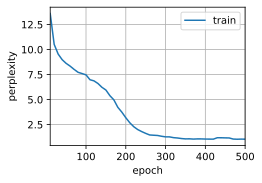

In [35]:
# 这行代码设置了训练的迭代周期数num_epochs为500，学习率lr为1。
num_epochs, lr = 500, 1
# 这行代码调用了train_ch8函数来进行模型训练。
# 它传递了神经网络模型net、训练数据迭代器train_iter、词汇表vocab、学习率lr、迭代周期数num_epochs和设备（尝试使用GPU）作为参数。
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

[**最后，让我们检查一下使用随机抽样方法的结果。**]


困惑度 1.5, 98112.4 词元/秒 cuda:0
time travellerit s against reason said filbywhac been batwooroan
travellerit s against reason said filby but you willnever c


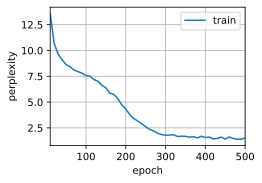

: 

In [36]:
# 这行代码创建了一个自定义的循环神经网络模型net，使用了RNNModelScratch类进行定义。
# 它接受参数包括词汇表的大小len(vocab)、
# 隐藏单元的数量num_hiddens、
# 设备（尝试使用GPU）d2l.try_gpu()、
# 获取模型参数的函数get_params、
# 初始化RNN状态的函数init_rnn_state和RNN单元的类型rnn。
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
# 这行代码调用了train_ch8函数来进行模型训练。它传递了自定义的循环神经网络模型net、
# 训练数据迭代器train_iter、词汇表vocab、学习率lr、迭代周期数num_epochs、设备（尝试使用GPU）和使用随机抽样的标志use_random_iter=True作为参数。
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)

# 该函数将使用给定的参数在训练数据上训练自定义的循环神经网络模型，并根据迭代周期的进展可视化困惑度，并打印生成的文本结果。

从零开始实现上述循环神经网络模型，
虽然有指导意义，但是并不方便。
在下一节中，我们将学习如何改进循环神经网络模型。
例如，如何使其实现地更容易，且运行速度更快。

## 小结

* 我们可以训练一个基于循环神经网络的字符级语言模型，根据用户提供的文本的前缀生成后续文本。
* 一个简单的循环神经网络语言模型包括输入编码、循环神经网络模型和输出生成。
* 循环神经网络模型在训练以前需要初始化状态，不过随机抽样和顺序划分使用初始化方法不同。
* 当使用顺序划分时，我们需要分离梯度以减少计算量。
* 在进行任何预测之前，模型通过预热期进行自我更新（例如，获得比初始值更好的隐状态）。
* 梯度裁剪可以防止梯度爆炸，但不能应对梯度消失。

## 练习

1. 尝试说明独热编码等价于为每个对象选择不同的嵌入表示。
1. 通过调整超参数（如迭代周期数、隐藏单元数、小批量数据的时间步数、学习率等）来改善困惑度。
    * 困惑度可以降到多少？
    * 用可学习的嵌入表示替换独热编码，是否会带来更好的表现？
    * 如果用H.G.Wells的其他书作为数据集时效果如何，
      例如[*世界大战*](http://www.gutenberg.org/ebooks/36)？
1. 修改预测函数，例如使用采样，而不是选择最有可能的下一个字符。
    * 会发生什么？
    * 调整模型使之偏向更可能的输出，例如，当$\alpha > 1$，从$q(x_t \mid x_{t-1}, \ldots, x_1) \propto P(x_t \mid x_{t-1}, \ldots, x_1)^\alpha$中采样。
1. 在不裁剪梯度的情况下运行本节中的代码会发生什么？
1. 更改顺序划分，使其不会从计算图中分离隐状态。运行时间会有变化吗？困惑度呢？
1. 用ReLU替换本节中使用的激活函数，并重复本节中的实验。我们还需要梯度裁剪吗？为什么？


[Discussions](https://discuss.d2l.ai/t/2103)
